In [21]:
import torch
import numpy as np
import pathlib

from PIL import Image
from matplotlib import pyplot as plt
import copy

In [22]:
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu")

class ImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        labels = np.asarray([dataset[i][1] for i in range(len(dataset))])
        data = np.asarray([dataset[i][0] for i in range(len(dataset))])
        
        self.img_labels = torch.from_numpy(labels)
        self.img_labels = self.img_labels.to(device)
        
        data = np.moveaxis(data, 3, 1)
        self.img_data = torch.from_numpy(data)
        self.img_data = self.img_data.to(device)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
       # return 10-times the size of the dataset because it is small and the augmentation is quite strong
        return len(self.img_labels)*10

    def __getitem__(self, idx):
        idx = idx % len(self.img_labels)
        image = self.img_data[idx]
        
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [23]:
import torch.nn as nn

X_train = list()
y_train = list()

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/pfannkuchen/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        X_train.append(pix)
        y_train.append(1)
        
length = len(X_train)

for file in pathlib.Path("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner").iterdir():
    if file.is_file() and file.suffix == ".bmp":
        pic = Image.open("/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/data/berliner/" + file.name)
        pix = np.asarray(pic)
        pix = pix / 255.0
        pix = pix.astype(np.float32)
        
        
        X_train.append(pix)
        y_train.append(0)
        if len(X_train) >= length*2:
            break #prevent one class from being overrepresented

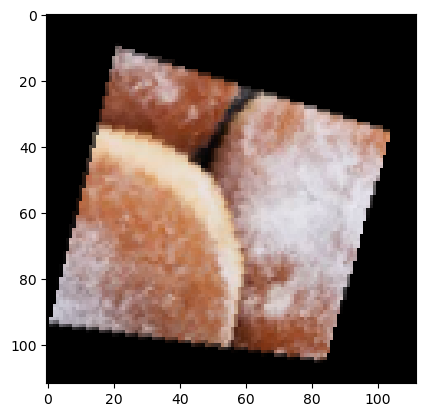

In [24]:
from torchvision import datasets, models, transforms

complete_dataset = np.asarray([[X_train[i], y_train[i]] for i in range(len(X_train))], dtype=object)

total_count = len(X_train)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count


train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    complete_dataset, (train_count, valid_count, test_count)
)

trainset = ImageDataset(train_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

testset = ImageDataset(test_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))

validset = ImageDataset(valid_dataset, transform=transforms.Compose([
    transforms.RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.7,1.33)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
    transforms.RandomRotation(degrees=(-45, 45))
]))


data, lbl = trainset.__getitem__(400)
data = np.asarray(data)
data = np.moveaxis(data, 0, 2)

plt.imshow(data) 
plt.show()


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 5, padding=2) 
        self.pool1 = nn.MaxPool2d(2, 2) # 56
        self.conv2 = nn.Conv2d(9, 27, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # 28
        self.conv3 = nn.Conv2d(27, 81, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # 14
        self.fc1 = nn.Linear(81 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = ConvNet()
net.to(device=device);

Epoch: 1, loss: 0.619: 100%|██████████| 83/83 [00:20<00:00,  3.96it/s]


------ Epoch 1 ------
avg. Train loss: 0.6682534943144005
Validation loss: 0.5955924267570177 | Validation accuracy: 0.6775000045696894


Epoch: 2, loss: 0.598: 100%|██████████| 83/83 [00:21<00:00,  3.91it/s]


------ Epoch 2 ------
avg. Train loss: 0.6036223101328655
Validation loss: 0.5978127991159757 | Validation accuracy: 0.6788888921340307


Epoch: 3, loss: 0.463: 100%|██████████| 83/83 [00:21<00:00,  3.89it/s]


------ Epoch 3 ------
avg. Train loss: 0.5482821267053305
Validation loss: 0.49751341591278714 | Validation accuracy: 0.7608333304524422


Epoch: 4, loss: 0.517: 100%|██████████| 83/83 [00:21<00:00,  3.86it/s]


------ Epoch 4 ------
avg. Train loss: 0.48869940064039574
Validation loss: 0.5179393440485001 | Validation accuracy: 0.748611107468605


Epoch: 5, loss: 0.313: 100%|██████████| 83/83 [00:21<00:00,  3.87it/s]


------ Epoch 5 ------
avg. Train loss: 0.4152310899941318
Validation loss: 0.5530938083926836 | Validation accuracy: 0.7388888821005821


Epoch: 6, loss: 0.283: 100%|██████████| 83/83 [00:21<00:00,  3.87it/s]


------ Epoch 6 ------
avg. Train loss: 0.41426214198750183
Validation loss: 0.4401797732959191 | Validation accuracy: 0.796666664381822


Epoch: 7, loss: 0.273: 100%|██████████| 83/83 [00:21<00:00,  3.90it/s]


------ Epoch 7 ------
avg. Train loss: 0.3080372620059783
Validation loss: 0.38118289535244304 | Validation accuracy: 0.8427777687708536


Epoch: 8, loss: 0.194: 100%|██████████| 83/83 [00:21<00:00,  3.88it/s]


------ Epoch 8 ------
avg. Train loss: 0.2635254061006638
Validation loss: 0.39511053698758286 | Validation accuracy: 0.8522222141424814


Epoch: 9, loss: 0.289: 100%|██████████| 83/83 [00:20<00:00,  4.00it/s] 


------ Epoch 9 ------
avg. Train loss: 0.2699895342250904
Validation loss: 0.42923694228132564 | Validation accuracy: 0.8474999939401945


Epoch: 10, loss: 0.137: 100%|██████████| 83/83 [00:20<00:00,  4.02it/s] 


------ Epoch 10 ------
avg. Train loss: 0.19538040916962796
Validation loss: 0.39640316429237527 | Validation accuracy: 0.8391666586200396
Finished Training


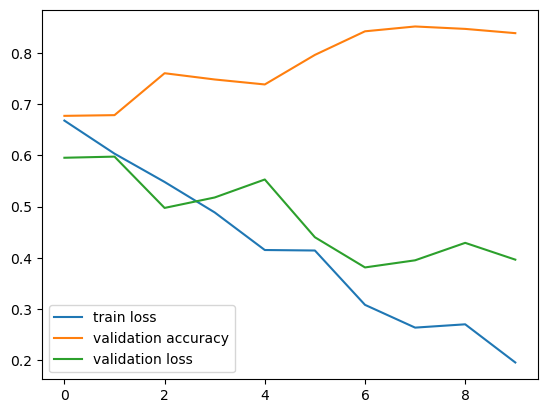

In [26]:

from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def train_model(model, optimizer, criterion=nn.CrossEntropyLoss(), epoch_count=10, batch_size=50):
    torch.manual_seed(42)
    best_acc = 0.0
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=0)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracys = []
    running_loss = []

    for epoch in range(epoch_count):  # loop over the dataset multiple times
        model.train(True)
        train_progress  = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", mininterval=0.3)
        for i, data in enumerate(train_progress, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # print statistics
            running_loss.append(loss.item())
            train_progress.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.3}")
        
        model.train(False)
        print(f"------ Epoch {epoch+1} ------")
    
        val_loss = 0
        val_accuracy = 0
        for i, data in enumerate(valid_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
        val_loss = val_loss / len(valid_dataloader)
        val_accuracy = val_accuracy / len(valid_dataloader)
        
        val_accuracys.append(val_accuracy)
        val_losses.append(val_loss)
        train_losses.append(sum(running_loss)/(len(running_loss)))
        
        if  val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"avg. Train loss: {sum(running_loss)/(len(train_dataloader))}")
        print(f"Validation loss: {val_loss} | Validation accuracy: {val_accuracy}")
        running_loss = []

    print('Finished Training')
    plt.plot(train_losses, label='train loss')
    plt.plot(val_accuracys, label='validation accuracy')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    
    model.load_state_dict(best_model_wts)
    
    return model

train_model(net, optim.Adam(net.parameters(), lr=0.001), epoch_count=10);

In [ ]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from torchvision.transforms import RandomResizedCrop

"""
trainset = ImageDataset(y_train, X_train, transform=transforms.Compose([
    #RandomResizedCrop(112, scale=(0.7,1.0), ratio=(0.5,2))
]))
ml_dataloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)

impr_trainset_data = []
impr_trainset_labels = []
for batch in ml_dataloader:
    data, lbl = batch
    lbl = np.asarray(lbl)[0]
    data = np.asarray(data)
    data = np.moveaxis(data, 0, 2)
    impr_trainset_data.append(data)
    impr_trainset_labels.append(lbl)

impr_trainset_labels = np.asarray(impr_trainset_labels)    
impr_trainset_data = np.asarray(impr_trainset_data)
impr_trainset_data = impr_trainset_data.reshape(-1, 3 * 112 * 112)
""";
impr_trainset_data = X_train.reshape(-1, 3 * 112 * 112)
impr_trainset_labels = y_train

model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', verbose=1)
model.fit(impr_trainset_data, impr_trainset_labels)

In [ ]:
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/ccd1103058108dca8975f3aa0e15024118d43058.bmp"
test_path = "/Users/robert/Documents/RepositorysLocal/BerlinerPfannkuchenKlassifikatior/BerlinerPfannkuchenKlassifikator/5d218a52d5657d1b40909b8805944b3f83b29c8d.bmp"
test_pic = Image.open(test_path)
test_data = np.asarray(test_pic)
test_data = (test_data / 255.0)
test_data = test_data.astype(np.float32)
test_data = test_data.reshape(-1, 3 , 112, 112)
test_data = torch.from_numpy(test_data)
test_data = test_data.reshape(-1, 3 * 112 * 112)

pred = model.predict(test_data)
pred

print(f'Actual value from test data is 0 and corresponding image is as below')
plt.matshow(test_data.reshape((112,112,3))) 
plt.show()
print(f'Predicted value from test data is {pred[0]} and corresponding image is as below')



In [28]:
def test_model(model, valid_dataloader, criterion=nn.CrossEntropyLoss()):
    model.train(False)
    val_loss = 0
    val_accuracy = 0

    #valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)

    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_accuracy += (outputs.argmax(dim=1) == labels).type(torch.float).mean().item()
    val_loss = val_loss / len(valid_dataloader)
    val_accuracy = val_accuracy / len(valid_dataloader)

    print("accuracy: {}".format(val_accuracy))
    print("loss: {}".format(val_loss))
    model.train(True)

valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=0)
test_model(net, valid_dataloader)

accuracy: 0.8601694915254238
loss: 0.3882016803762935
